In [1]:
%cd ..

D:\Tesis\REPO\Cloud-Classification\code


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt

In [4]:
import os
from torchvision.io import read_image
import torchvision.transforms as T
import torch.nn as nn
import torch.nn.functional as F
import networkx as nx

In [5]:
from src import config
from src import engine
from src import utils

Using backend: pytorch


In [6]:
from recipe.utils import *

In [184]:
import random
from random import sample
from torchvision.utils import save_image

In [25]:
torch.manual_seed(7)
np.random.seed(7)
random.seed(7)

---

In [8]:
def get_targets(paths):
        return list(map(int,list(map(int,[os.path.basename(x).split('_')[0] 
                                          for x in paths]))))

In [40]:
def plot_image(img):
    plt.imshow(img.numpy().transpose(1,2,0))
    plt.show()

In [203]:
import matplotlib

def save_tensor_image(img, path):
    matplotlib.image.imsave(path, img.numpy().transpose(1,2,0))

---

# Read data

In [9]:
paths = utils.get_gcd_paths('D:\Tesis\REPO','train')
targets = get_targets(paths)

In [10]:
df_train = pd.DataFrame({'path':paths, 'target':targets})

In [11]:
df_train.head()

path  target
0  D:\Tesis\REPO\GCD/train\1_cumulus\1_cumulus_00...       1
1  D:\Tesis\REPO\GCD/train\1_cumulus\1_cumulus_00...       1
2  D:\Tesis\REPO\GCD/train\1_cumulus\1_cumulus_00...       1
3  D:\Tesis\REPO\GCD/train\1_cumulus\1_cumulus_00...       1
4  D:\Tesis\REPO\GCD/train\1_cumulus\1_cumulus_00...       1

# Data distribution

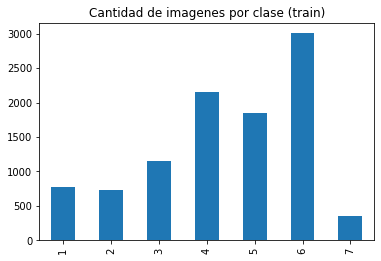

In [90]:
order = [i for i in range(1,8)]

df_train['target'].value_counts()[order].plot.bar()
plt.title('Cantidad de imagenes por clase (train)')
plt.show()

# Data Augmentation

## Image sample 

In [41]:
img = read_image(paths[0]).int()
plot_image(img)

## Horizontal Flip

In [48]:
hflip_transform = T.RandomHorizontalFlip(p=1)

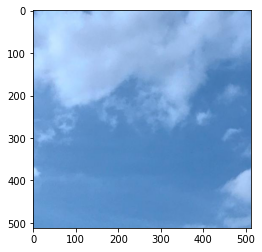

In [49]:
hflip_img = hflip_transform(img)
plot_image(hflip_img)

## Random Rotation

In [81]:
lrot_transform = T.RandomRotation([-12,-5])
rrot_transform = T.RandomRotation([5,15])

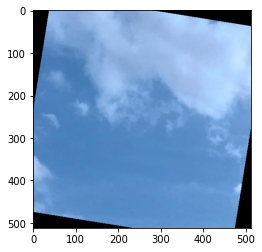

In [82]:
lrot_img = lrot_transform(img)
plot_image(lrot_img)

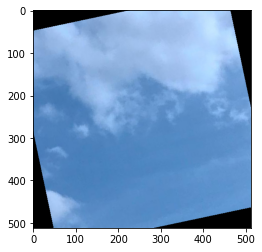

In [84]:
rrot_img = rrot_transform(img)
plot_image(rrot_img)

In [198]:
rrot_img.dtype

torch.int32

In [194]:
random_images =torch.rand(64, 3,28,28)

In [196]:
random_images[0].dtype

torch.float32

In [197]:
save_image(random_images[0], 'a.jpg')

## Crear dataset con imágenes aumentadas (offline data augmentation)

In [258]:
df_train['img_name'] = df_train['path'].apply(lambda x: x.split('\\')[-1].split('.')[0])

In [172]:
paths_array = np.array(paths)
targets_array = np.array(targets)
img_names_array = np.array(df_train['img_name'].values)

In [240]:
class_augmentation = {
    1: ['hflip', 'lrot', 'rrot'],
    2: ['hflip', 'lrot', 'rrot'],
    3: ['hflip', 'lrot'],
    4: ['hflip'],
    5: ['hflip'],
    6: [],
    7: ['hflip', 'lrot', 'rrot'],
}


class_names = {
    1: 'cumulus',
    2: 'altocumulus',
    3: 'cirrus',
    4: 'clearsky',
    5: 'stratocumulus',
    6: 'cumulonimbus',
    7: 'mixed',
}

In [241]:
# _paths_array = np.array(paths_array[0:5])
# _targets_array = np.array(targets_array[0:5])
# _img_names_array = img_names_array[0:5]

In [244]:
### TRANSFORMERS
hflip_transform = T.RandomHorizontalFlip(p=1)
lrot_transform = T.RandomRotation([-12,-5])
rrot_transform = T.RandomRotation([5,15])


for c in tqdm(class_augmentation.keys()):
    indexes = np.where(targets_array==c)[0]
    
    if c in [4,5]:
        indexes = np.random.permutation(indexes)[:len(indexes)//2]
    
    save_base = f'D:/Tesis/REPO/GCD/augmentation/{c}_{class_names[c]}/'
    
    for i in indexes:
        img = read_image(paths_array[i])
        #plot_image(img)
        
        for augmentation in class_augmentation[c]:
            
            save_path = save_base + img_names_array[i] + f'_{augmentation}.jpg'
            
            if augmentation=='hflip':
                aug_img = hflip_transform(img)
                #plot_image(aug_img)
            elif augmentation=='lrot':
                aug_img = lrot_transform(img)
                #plot_image(aug_img)
            elif augmentation=='rrot':
                aug_img = rrot_transform(img)
                #plot_image(aug_img)

            save_tensor_image(aug_img,save_path)

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:30<00:00, 21.50s/it]


---

# Resultados del Data Augmentation

In [259]:
df_train['type'] = 'train'

### Leer paths e imagenes resultado de augmentation

In [253]:
aug_paths = utils.get_gcd_paths('D:\Tesis\REPO','augmentation')
aug_targets = get_targets(aug_paths)

In [254]:
df_augmentation = pd.DataFrame({
    'path': aug_paths,
    'target': aug_targets,
})

In [255]:
df_augmentation['img_name'] = df_augmentation['path'].apply(lambda x: x.split('\\')[-1].split('.')[0])

In [260]:
df_augmentation['type'] = 'augmentation'

### Concatenar datasets y ver resultados

In [262]:
df_final = pd.concat([df_train, df_augmentation], axis=0)

In [264]:
order = [i for i in range(1,8)]

df_final['target'].value_counts()[order].plot.bar()
plt.title('Cantidad de imagenes por clase (train + augmentation)')
plt.show()